<a href="https://colab.research.google.com/github/effieklestz/Chesapeake/blob/main/Chesapeak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from google.colab import files

uploaded = files.upload()

Saving JCOBYDIVISION (1).csv to JCOBYDIVISION (1).csv


In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime


In [33]:
# Assuming your CSV file is named 'example.csv'
df = pd.read_csv('JCOBYDIVISION (1).csv')

In [34]:
def convertDatatypes(df):
    column_names = df.columns.to_numpy()
    column_types = df.dtypes
    filtered_column_names = [col for col in column_names if column_types[col] != float]
    filtered_column_names = [col for col in filtered_column_names if col != 'Months in Transaction Date']
    for col in filtered_column_names:
        df[col] = df[col].astype(str)
        df[col] = df[col].str.replace(',', '')
        df[col] = df[col].str.replace('/', '')
        df[col] = df[col].astype(float)
        df[col].fillna(0, inplace=True)
    return df
df = convertDatatypes(df)

In [35]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

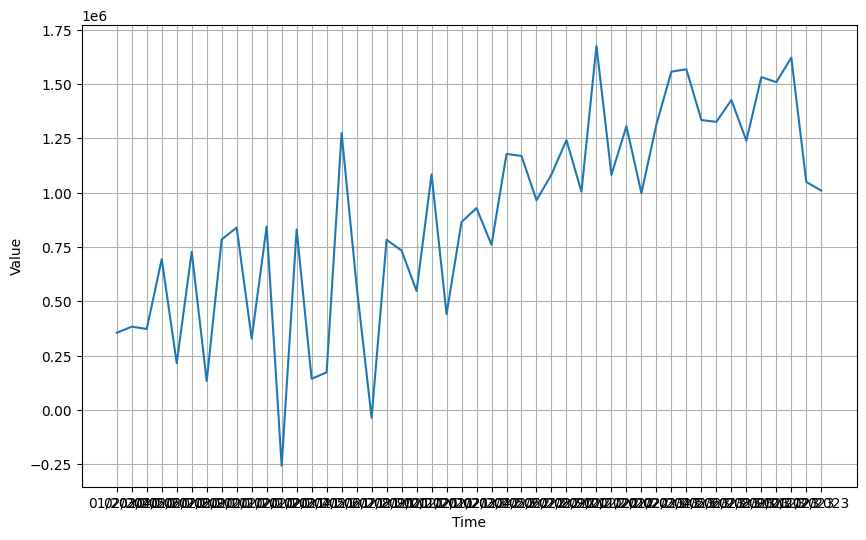

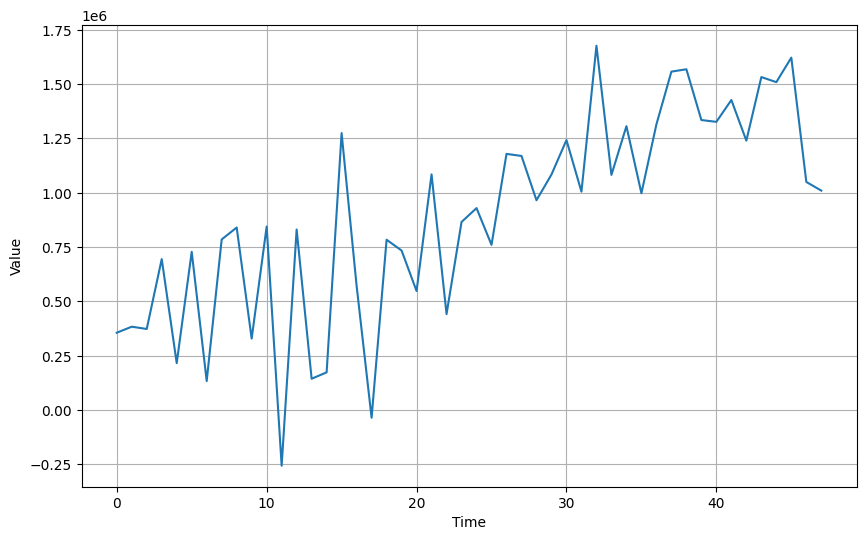

In [37]:
#Remove 2024 Data and add index as column
# df = df[df['Months in Transaction Date'] != '01/2024']
df['index_as_column'] = df.index

plot_series(df['Months in Transaction Date'],df['GP'])
plot_series(df['index_as_column'],df['GP'])


In [38]:
# Define the split time
split_time = 30
uni_list = ['index_as_column','GP']

time = df['index_as_column']
series = df['GP']
df_uni = df[uni_list]

# time = df['DateColumnInSeconds']
# series = df['GP']

# Create a Boolean
train_mask = df_uni['index_as_column']< split_time
valid_mask = ~train_mask

# Get the train set
time_train = df_uni.loc[train_mask,'index_as_column']
x_train = df_uni.loc[train_mask,'GP']
# Get the validation set
time_valid = df_uni.loc[valid_mask, 'index_as_column']
x_valid = df_uni.loc[valid_mask,'GP']

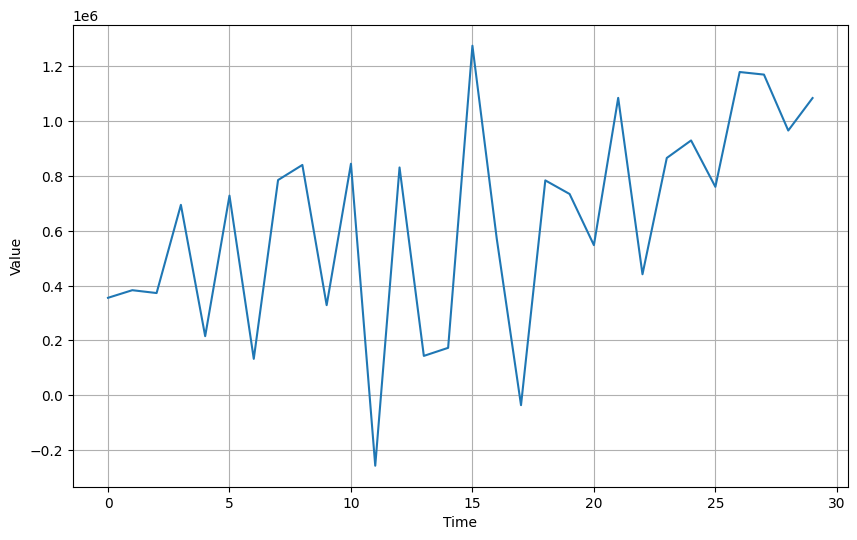

In [39]:
plot_series(time_train, x_train)

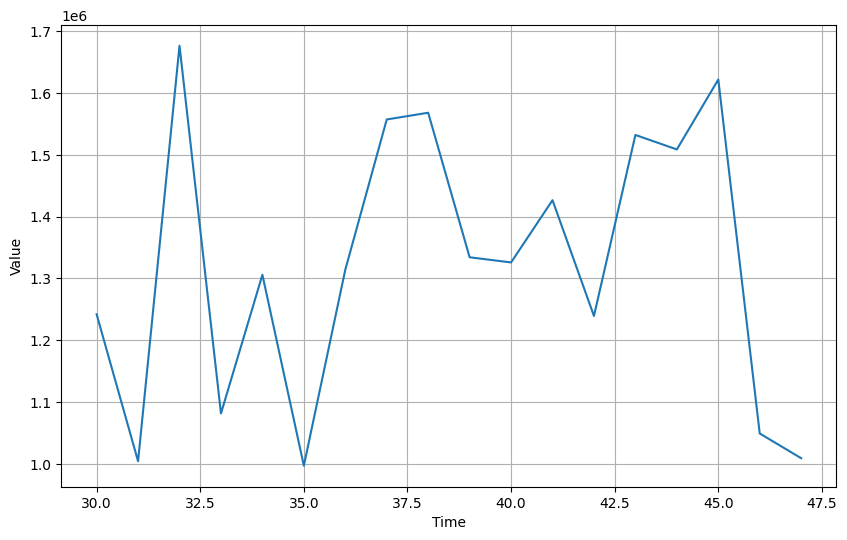

In [40]:
# Plot the validation set
plot_series(time_valid, x_valid)

In [13]:
# Generate the naive forecast
naive_forecast = series[(split_time -1):-1]

# Define time step
time_step = 150

# Print values
print(f'ground truth at time step {time_step}: {x_valid[time_step]}')
print(f'prediction at time step {time_step + 1}: {naive_forecast[time_step+1]}')

ground truth at time step 150: -208236.66000000096
prediction at time step 151: 77062.72999999986


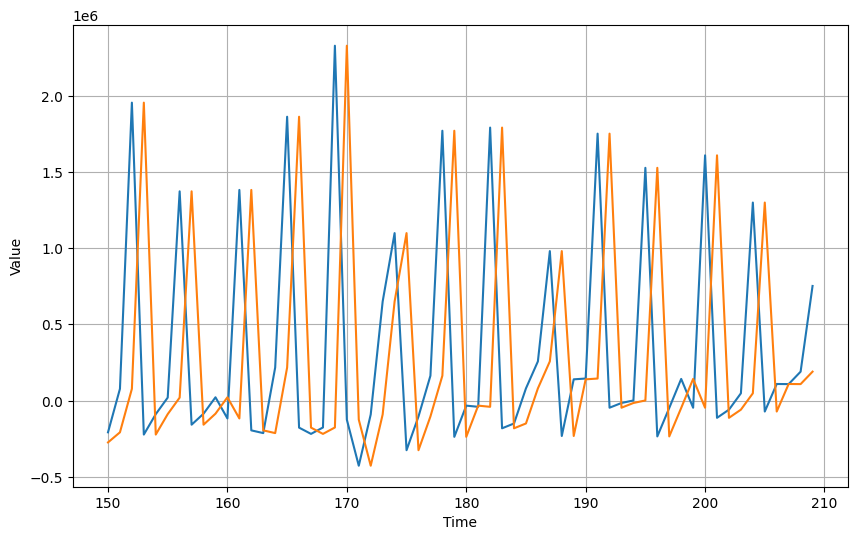

In [14]:
# Plot the results
plot_series(time_valid, (x_valid, naive_forecast))

In [15]:
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

1279268039541.9443
808559.993166667


In [41]:
def moving_average_forecast(series, window_size):
    """Generates a moving average forecast

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to compute the average for

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Initialize a list
    forecast = []

    # Compute the moving average based on the window size
    for time in range(len(series) - window_size):
      forecast.append(series[time:time + window_size].mean())

    # Convert to a numpy array
    forecast = np.array(forecast)

    return forecast

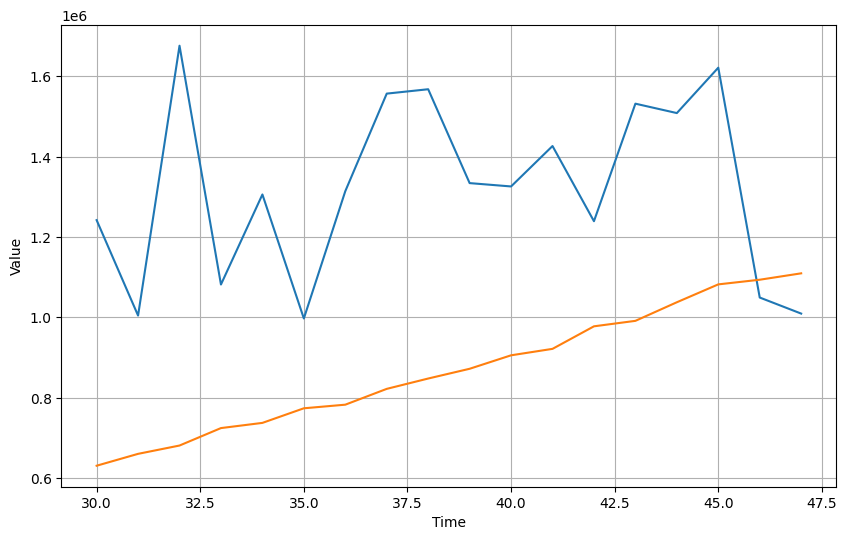

In [42]:
# Generate the moving average forecast
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

# Plot the results
plot_series(time_valid, (x_valid, moving_avg))

In [43]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

269786891527.4885
468441.90988888603


In [44]:
# Parameters
window_size = 3
batch_size = 5
shuffle_buffer_size = 100

In [45]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [46]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [50]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 3, 1)              0         
                                                                 
 bidirectional (Bidirection  (None, 3, 64)             8704      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33601 (131.25 KB)
Trainable params: 3360

In [54]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
6/6 [==============================] - 8s 17ms/step - loss: 517052.2500 - lr: 1.0000e-04
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 516408.0625 - lr: 1.1220e-04
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 515087.2500 - lr: 1.2589e-04
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 513712.5938 - lr: 1.4125e-04
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 511740.7188 - lr: 1.5849e-04
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 509908.9375 - lr: 1.7783e-04
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 507972.8750 - lr: 1.9953e-04
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 505442.0000 - lr: 2.2387e-04
Epoch 9/100
6/6 [==============================] - 0s 7ms/step - loss: 503070.5938 - lr: 2.5119e-04
Epoch 10/100
6/6 [==============================] - 0s 6ms/step - loss: 500492.4375 - lr: 2.8184e-

(0.0001, 0.1, 0.0, 1000000.0)

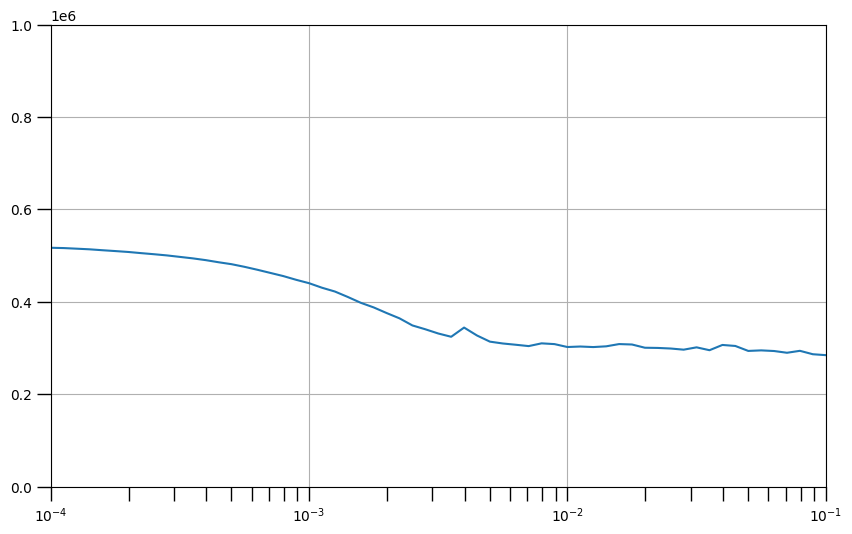

In [57]:
# Define the learning rate array
lrs = 1e-4 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-4, 1e-1, 0, 1000000])

In [61]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 0.01

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
6/6 [==============================] - 10s 17ms/step - loss: 675464.4375 - mae: 675464.9375
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 596900.5625 - mae: 596901.1250
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 476448.3750 - mae: 476448.8750
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 382269.5625 - mae: 382270.0312
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 322285.3438 - mae: 322285.8438
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 319736.1875 - mae: 319736.7188
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 318896.5312 - mae: 318897.0000
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 309894.6250 - mae: 309895.1250
Epoch 9/100
6/6 [==============================] - 0s 7ms/step - loss: 302861.1875 - mae: 302861.6875
Epoch 10/100
6/6 [==============================] - 0s 7ms/step - loss: 305743.3

In [62]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

4/4 [==============================] - 0s 11ms/step


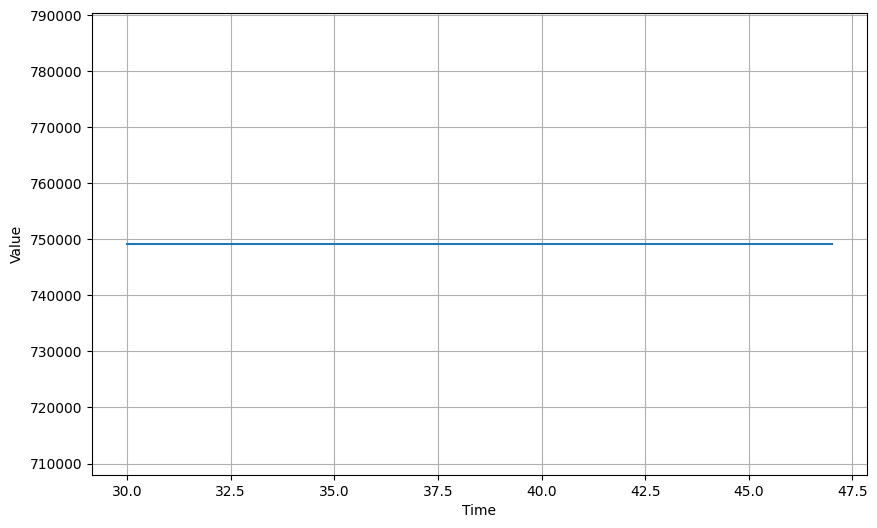

In [64]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))